## Red Wine Quality Prediction Project

Project Description
The dataset is related to red and white variants of the Portuguese "Vinho Verde" wine. Due to privacy
and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available 
(e.g. there is no data about grape types, wine brand, wine selling price, etc.).

This dataset can be viewed as classification task. The classes are ordered and not balanced 
(e.g. there are many more normal wines than excellent or poor ones). Also, we are not sure if all 
input variables are relevant. So it could be interesting to test feature selection methods.


Attribute Information
Input variables (based on physicochemical tests):
1 - fixed acidity
2 - volatile acidity
3 - citric acid
4 - residual sugar
5 - chlorides
6 - free sulfur dioxide
7 - total sulfur dioxide
8 - density
9 - pH
10 - sulphates
11 - alcohol
Output variable (based on sensory data):
12 - quality (score between 0 and 10)


What might be an interesting thing to do, is to set an arbitrary cutoff for your dependent variable 
(wine quality) at e.g. 7 or higher getting classified as 'good/1' and the remainder as 'not good/0'.
This allows you to practice with hyper parameter tuning on e.g. decision tree algorithms looking at 
the ROC curve and the AUC value.

You need to build a classification model. 


Inspiration:
    
Use machine learning to determine which physiochemical properties make a wine 'good'!


Dataset Link

https://github.com/dsrscientist/DSData/blob/master/winequality-red.csv


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, accuracy_score, roc_auc_score, auc

from sklearn.model_selection import cross_val_score

## Data Collection

In [2]:
wine_quality_df = pd.read_csv("https://raw.githubusercontent.com/dsrscientist/DSData/master/winequality-red.csv")
wine_quality_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


## Exploratory Data Analysis

In [3]:
wine_quality_df.shape

(1599, 12)

In [4]:
wine_quality_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


Observation:
            1. No null values in any columns
            2. Almost all columns are of type - float64

In [5]:
wine_quality_df.sample(n = 10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1023,8.2,0.320,0.42,2.3,0.098,3.0,9.0,0.99506,3.27,0.55,12.3,6
976,7.2,0.410,0.30,2.1,0.083,35.0,72.0,0.99700,3.44,0.52,9.4,5
1281,7.1,0.460,0.20,1.9,0.077,28.0,54.0,0.99560,3.37,0.64,10.4,6
1530,6.6,0.440,0.09,2.2,0.063,9.0,18.0,0.99444,3.42,0.69,11.3,6
367,10.4,0.575,0.61,2.6,0.076,11.0,24.0,1.00000,3.16,0.69,9.0,5
836,6.7,0.280,0.28,2.4,0.012,36.0,100.0,0.99064,3.26,0.39,11.7,7
1481,8.2,0.280,0.60,3.0,0.104,10.0,22.0,0.99828,3.39,0.68,10.6,5
1229,7.6,0.430,0.29,2.1,0.075,19.0,66.0,0.99718,3.40,0.64,9.5,5
178,7.0,0.805,0.00,2.5,0.068,7.0,20.0,0.99690,3.48,0.56,9.6,5
955,8.5,0.210,0.52,1.9,0.090,9.0,23.0,0.99648,3.36,0.67,10.4,5


In [6]:
wine_quality_df.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [7]:
wine_quality_df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Observation:
            1. No null values in any columns

In [8]:
wine_quality_df.columns.tolist()

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

In [9]:
# check for any blank records

wine_quality_df.loc[wine_quality_df['alcohol'] == ' ']   

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality


Observation:
            1. checked all 12 columns but none have any blank values

In [10]:
wine_quality_df.shape

(1599, 12)

In [11]:
# check the duplicate values in rows

wine_quality_df.duplicated().sum()

240

In [12]:
# remove 240 duplicate values in rows

wine_quality_df.drop_duplicates(ignore_index = True, inplace = True)

In [13]:
wine_quality_df.shape

(1359, 12)

Observation:
            1. Almost 240 duplicate values in rows we found and so deleted 

In [14]:
# Number of uniques values in each column 

wine_quality_df.nunique().to_frame("No. of Unique Values")

,No. of Unique Values
fixed acidity,96
volatile acidity,143
citric acid,80
residual sugar,91
chlorides,153
free sulfur dioxide,60
total sulfur dioxide,144
density,436
pH,89
sulphates,96


In [15]:
wine_quality_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.660,0.00,1.8,0.075,13.0,40.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1354,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
1355,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1356,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1357,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [16]:
wine_quality_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,8.310596,0.529478,0.272333,2.523400,0.088124,15.893304,46.825975,0.996709,3.309787,0.658705,10.432315,5.623252
std,1.736990,0.183031,0.195537,1.352314,0.049377,10.447270,33.408946,0.001869,0.155036,0.170667,1.082065,0.823578
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996700,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.430000,2.600000,0.091000,21.000000,63.000000,0.997820,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Observations:
            1. No missing values
            2. Mean value is > median value so it is right skew and postively correlated
            3. Standard Deviation cannot be more than mean value
            4. Looks like there are quite more number of outliers

## Data Visualization

5    577
6    535
7    167
4     53
8     17
3     10
Name: quality, dtype: int64


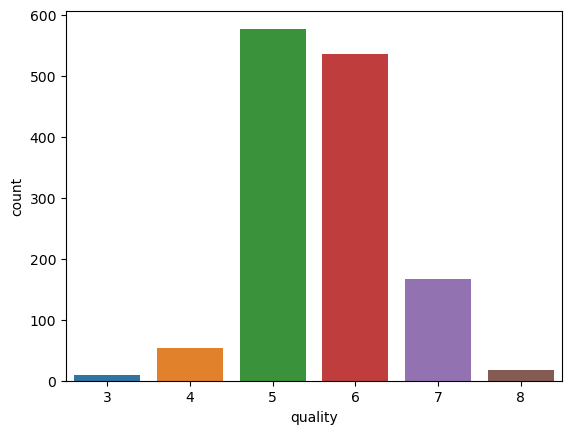

In [17]:
# count the number of quality of the wine

sns.countplot(x = 'quality', data = wine_quality_df)
print(wine_quality_df.quality.value_counts())

Observation:
            1. There are different classes like 3, 4, 5, 6, 7 and 8 (i.e. six classes)
            2. There are very less number of wine quality value 3, 4 and 8
            3. we will reduce six classes into two classes, so that we have "good" or "bad" quality
            4. Data is imbalanced so use oversampling method.

<AxesSubplot:xlabel='quality', ylabel='fixed acidity'>

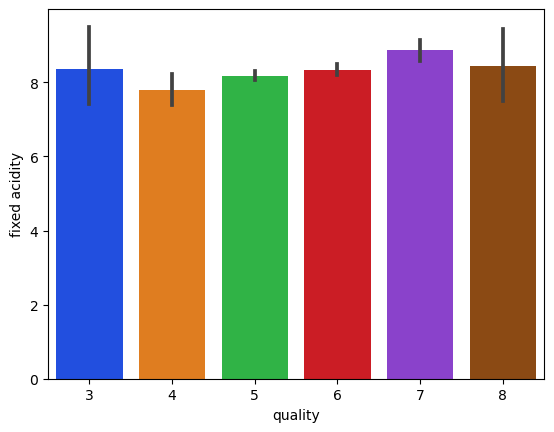

In [19]:
# plot fixed acidity v/s Quality of wine

sns.barplot(x = 'quality', y = 'fixed acidity', data = wine_quality_df, palette = 'bright')

<AxesSubplot:xlabel='quality', ylabel='volatile acidity'>

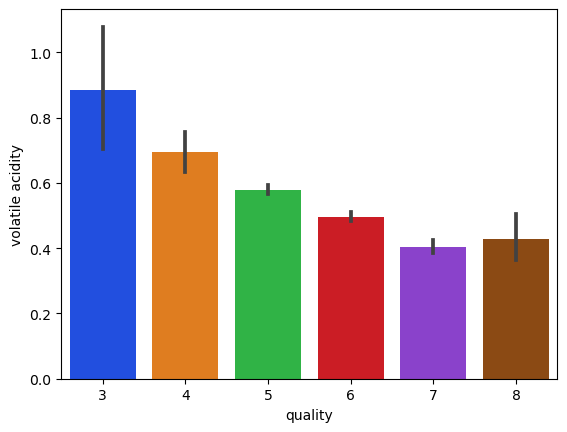

In [20]:
# plot volatile acidity v/s Quality of wine

sns.barplot(x = 'quality', y = 'volatile acidity', data = wine_quality_df, palette = 'bright')

<AxesSubplot:xlabel='quality', ylabel='citric acid'>

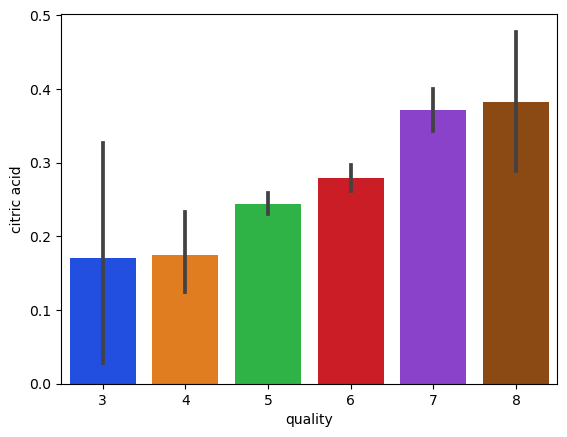

In [21]:
# plot citric acid v/s Quality of wine

sns.barplot(x = 'quality', y = 'citric acid', data = wine_quality_df, palette = 'bright')

<AxesSubplot:xlabel='quality', ylabel='residual sugar'>

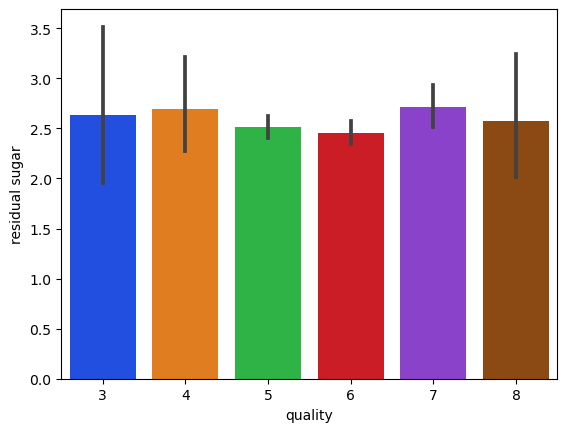

In [22]:
# plot residual sugar v/s Quality of wine

sns.barplot(x = 'quality', y = 'residual sugar', data = wine_quality_df, palette = 'bright')

<AxesSubplot:xlabel='quality', ylabel='chlorides'>

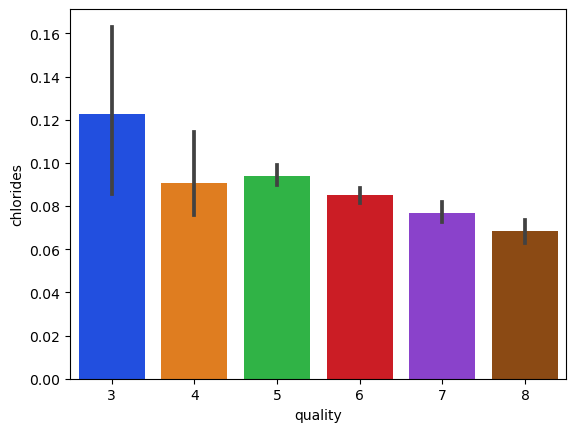

In [23]:
# plot chlorides v/s Quality of wine

sns.barplot(x = 'quality', y = 'chlorides', data = wine_quality_df, palette = 'bright')

<AxesSubplot:xlabel='quality', ylabel='alcohol'>

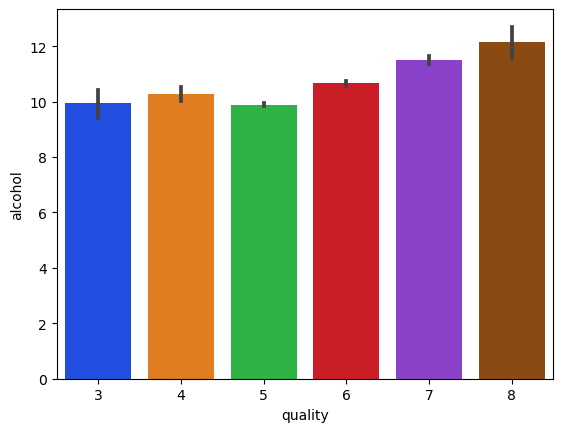

In [24]:
# plot alcohol v/s Quality of wine

sns.barplot(x = 'quality', y = 'alcohol', data = wine_quality_df, palette = 'bright')

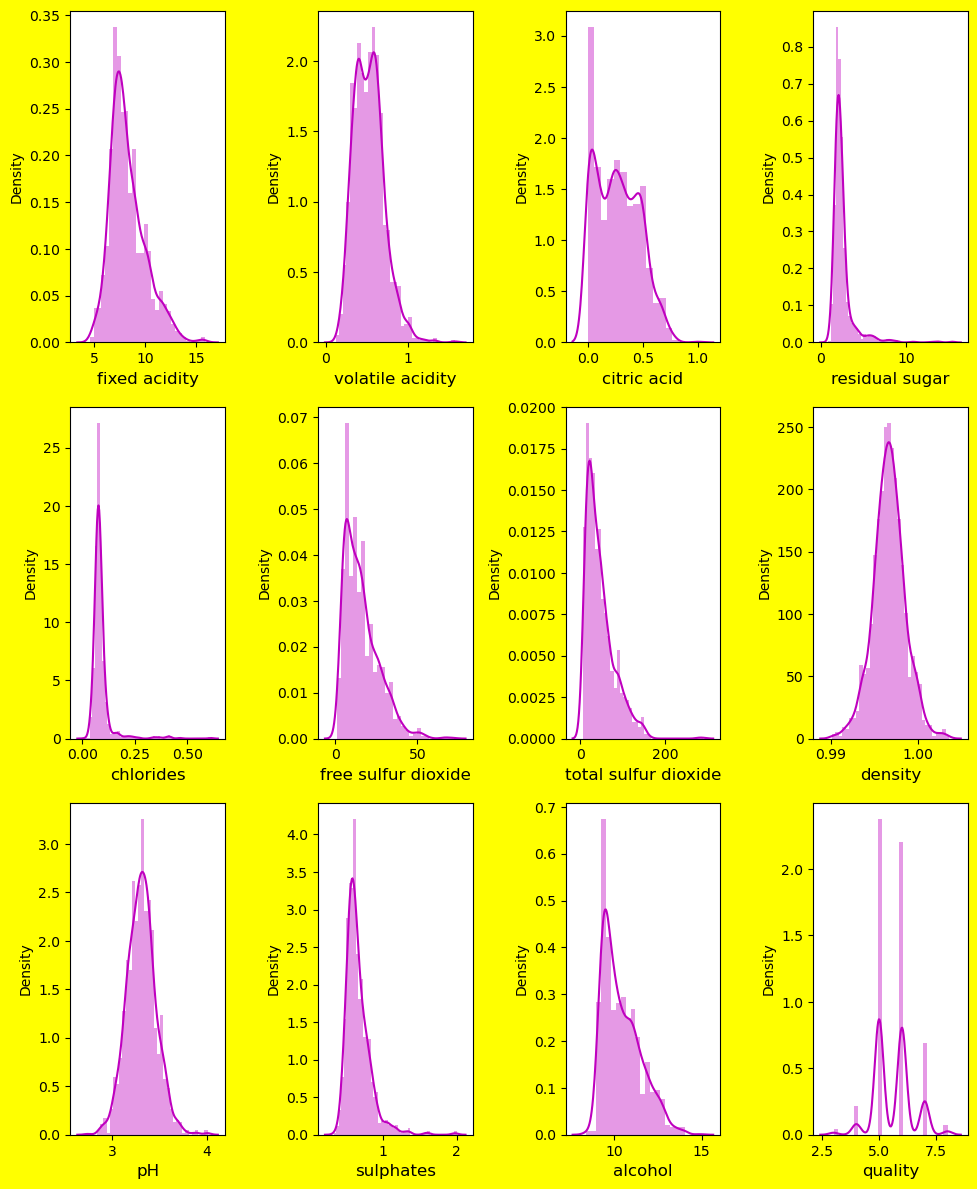

In [25]:
# lets see how data is distributed for every column

plt.figure(figsize=(10,12), facecolor = 'yellow')
p = 1
for i in wine_quality_df:
    if p <= 12:
        ax = plt.subplot(3, 4, p)
        sns.distplot(wine_quality_df[i], color = 'm')
        plt.xlabel(i, fontsize = 12)
    p = p + 1
plt.tight_layout()

observation:
        1. There are lot of outliers - Looks like we should also deal with outliers
        2. we need to deal with skewness in the data - most of the variables right skewness are there 

In [26]:
wine_quality_df.shape

(1359, 12)

## Check for Multicollinearity

## Data Correlation find - whether we need all 12 columns

In [27]:
# get coefficient of one variable with all the other variables

cor = wine_quality_df.corr()
cor

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.255124,0.667437,0.111025,0.085886,-0.140580,-0.103777,0.670195,-0.686685,0.190269,-0.061596,0.119024
volatile acidity,-0.255124,1.000000,-0.551248,-0.002449,0.055154,-0.020945,0.071701,0.023943,0.247111,-0.256948,-0.197812,-0.395214
citric acid,0.667437,-0.551248,1.000000,0.143892,0.210195,-0.048004,0.047358,0.357962,-0.550310,0.326062,0.105108,0.228057
residual sugar,0.111025,-0.002449,0.143892,1.000000,0.026656,0.160527,0.201038,0.324522,-0.083143,-0.011837,0.063281,0.013640
chlorides,0.085886,0.055154,0.210195,0.026656,1.000000,0.000749,0.045773,0.193592,-0.270893,0.394557,-0.223824,-0.130988
free sulfur dioxide,-0.140580,-0.020945,-0.048004,0.160527,0.000749,1.000000,0.667246,-0.018071,0.056631,0.054126,-0.080125,-0.050463
total sulfur dioxide,-0.103777,0.071701,0.047358,0.201038,0.045773,0.667246,1.000000,0.078141,-0.079257,0.035291,-0.217829,-0.177855
density,0.670195,0.023943,0.357962,0.324522,0.193592,-0.018071,0.078141,1.000000,-0.355617,0.146036,-0.504995,-0.184252
pH,-0.686685,0.247111,-0.550310,-0.083143,-0.270893,0.056631,-0.079257,-0.355617,1.000000,-0.214134,0.213418,-0.055245
sulphates,0.190269,-0.256948,0.326062,-0.011837,0.394557,0.054126,0.035291,0.146036,-0.214134,1.000000,0.091621,0.248835


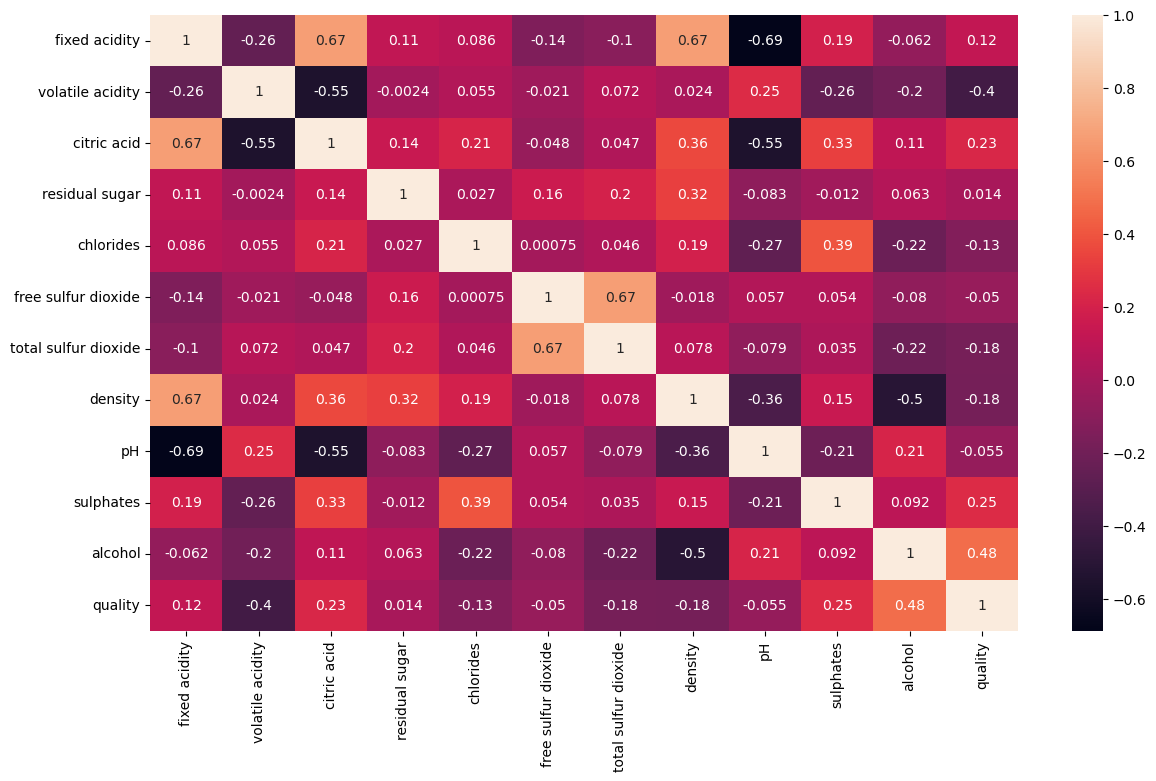

In [28]:
# visualize correlation using heatmap

plt.figure(figsize = (14, 8))
sns.heatmap(cor, annot = True, annot_kws = {'size' : 10})
plt.show()

In [ ]:
Observation:
            1. feature v/s feature - 'fixed acidity' v/s 'pH' has more negative correlation -0.69
               This shows there might be multicollinearity issue but we need one more 
               proof so will plot scatter plot and check

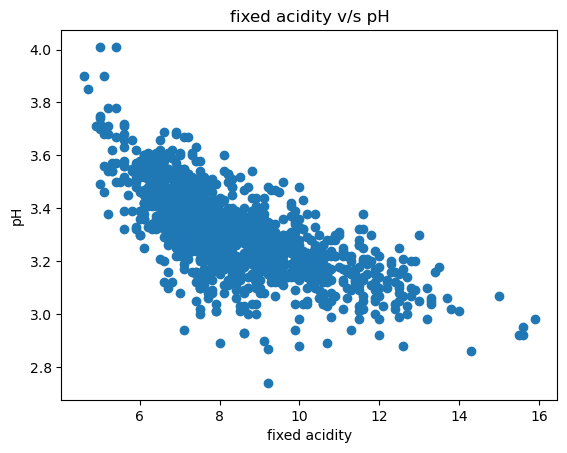

In [29]:
# one more proof so will plot scatter plot and check

plt.scatter(wine_quality_df['fixed acidity'], wine_quality_df.pH)
plt.xlabel("fixed acidity")
plt.ylabel("pH")
plt.title("fixed acidity v/s pH")
plt.show()

In [ ]:
Observation:
            1. feature v/s feature - 'fixed acidity' v/s 'pH' from this scatter plot, we got to
               know that there is multicollinearity issue between these two features - 
               as 'fixed acidity' increases 'pH' value decreases - negative correlation

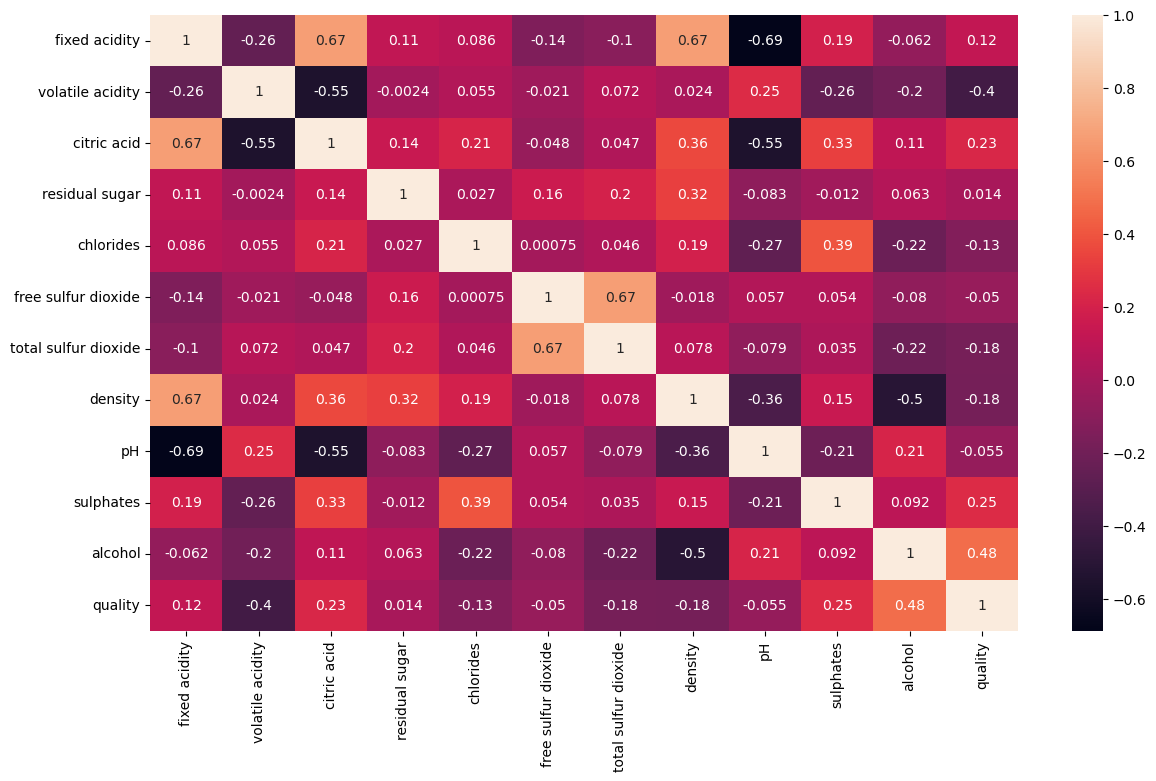

In [30]:
# Now check through heat map 'fixed acidity' or 'pH' is contributing more correlation
#  to the label keep that and drop the other one

plt.figure(figsize = (14, 8))
sns.heatmap(cor, annot = True, annot_kws = {'size' : 10})
plt.show()

In [ ]:
Observation:
            1. feature v/s label - 'fixed acidity' v/s 'quality' is 0.12 and 
               'pH' v/s 'quality' is -0.055 from this heatmap we get to know 'fixed acidity' 
               is contributing more to 'quality' than 'pH'. so we can remove 'pH' feature.
                
            2. feature v/s feature - 'fixed acidity' v/s 'density' and 'fixed acidity' v/s 'citric acid' 
               has positive correlation 0.67. This shows there might be multicollinearity issue 
               but we need one more proof so will plot scatter plot and check

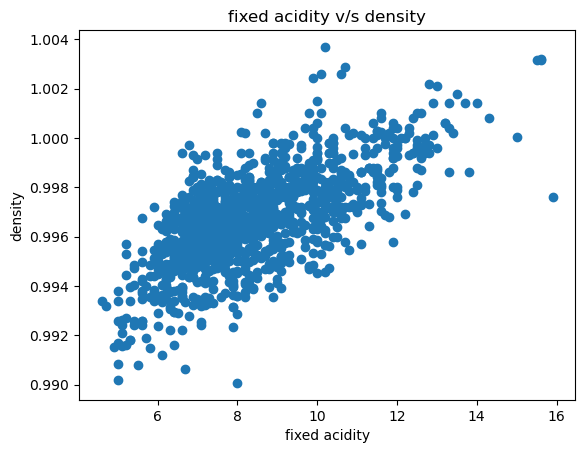

In [31]:
# one more proof so will plot scatter plot and check

plt.scatter(wine_quality_df['fixed acidity'], wine_quality_df.density)
plt.xlabel("fixed acidity")
plt.ylabel("density")
plt.title("fixed acidity v/s density")
plt.show()

In [ ]:
Observation:
            1. feature v/s feature - 'fixed acidity' v/s 'density' from this scatter plot, we got to
               know that there is multicollinearity issue between these two features - 
               as 'fixed acidity' increases 'density' value increases - positive correlation

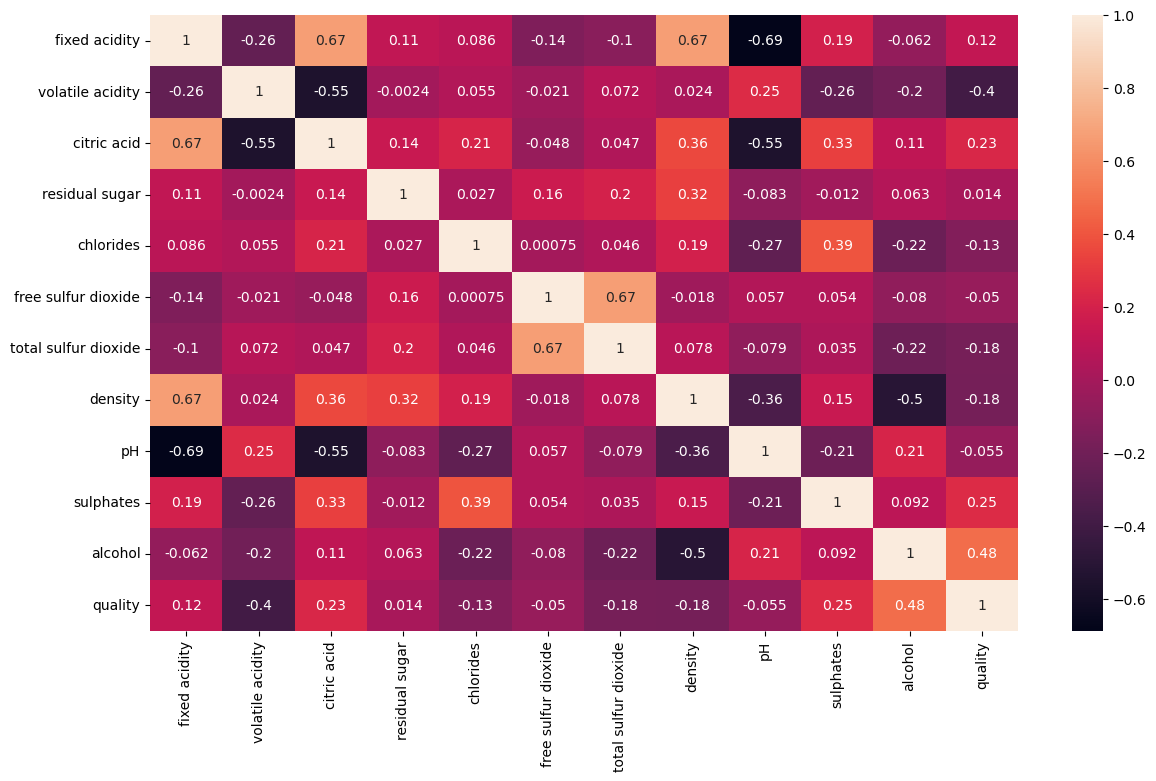

In [32]:
# Now check through heat map 'fixed acidity' or 'density' is contributing more correlation
#  to the label keep that and drop the other one

plt.figure(figsize = (14, 8))
sns.heatmap(cor, annot = True, annot_kws = {'size' : 10})
plt.show()

Observation:
            1. feature v/s label - 'fixed acidity' v/s 'quality' is 0.12 and 
               'density' v/s 'quality' is -0.18 from this heatmap we get to know 'fixed acidity' 
               is contributing more to 'quality' than 'density'. so we can remove 'density' feature.

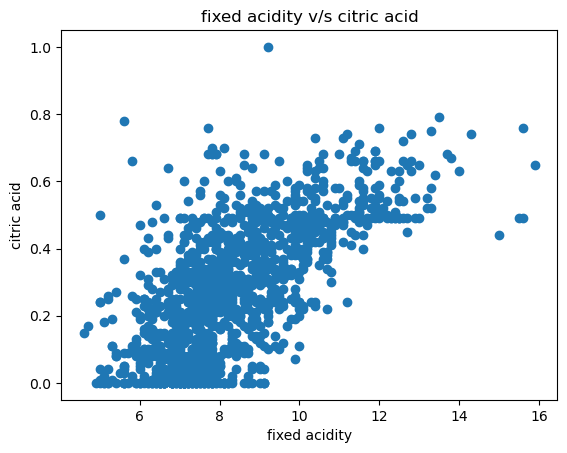

In [33]:
# one more proof so will plot scatter plot and check

plt.scatter(wine_quality_df['fixed acidity'], wine_quality_df['citric acid'])
plt.xlabel("fixed acidity")
plt.ylabel("citric acid")
plt.title("fixed acidity v/s citric acid")
plt.show()

In [34]:
# correlation of all features with the target column - 'quality'

cor['quality'].sort_values(ascending = False)   

quality                 1.000000
alcohol                 0.480343
sulphates               0.248835
citric acid             0.228057
fixed acidity           0.119024
residual sugar          0.013640
free sulfur dioxide    -0.050463
pH                     -0.055245
chlorides              -0.130988
total sulfur dioxide   -0.177855
density                -0.184252
volatile acidity       -0.395214
Name: quality, dtype: float64

In [35]:
wine_quality_df.drop(columns = ['pH', 'density'], axis = 1, inplace = True)
wine_quality_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.58,9.8,6
4,7.4,0.660,0.00,1.8,0.075,13.0,40.0,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...
1354,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.82,9.5,6
1355,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.58,10.5,5
1356,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.76,11.2,6
1357,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.71,10.2,5


## Seperating features and target

In [36]:
wine_quality_df.shape

(1359, 10)

In [37]:
x = wine_quality_df.drop(columns = ['quality'])
y = wine_quality_df['quality']

In [38]:
x

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,sulphates,alcohol
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.56,9.4
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.68,9.8
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.65,9.8
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.58,9.8
4,7.4,0.660,0.00,1.8,0.075,13.0,40.0,0.56,9.4
...,...,...,...,...,...,...,...,...,...
1354,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.82,9.5
1355,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.58,10.5
1356,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.76,11.2
1357,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.71,10.2


In [39]:
y

0       5
1       5
2       5
3       6
4       5
       ..
1354    6
1355    5
1356    6
1357    5
1358    6
Name: quality, Length: 1359, dtype: int64

## One more proof to check for Multicollinearity problem - use Variance Inflation Factor (VIF)

In [40]:
# Feature Scaling using Standard Scalarization

from sklearn.preprocessing import StandardScaler

s = StandardScaler()
x_scaled = s.fit_transform(x)
x_scaled

array([[-0.52443096,  0.93200015, -1.39325797, ..., -0.38404973,
        -0.57856134, -0.95437429],
       [-0.29406274,  1.91580043, -1.39325797, ...,  0.60407328,
         0.12482157, -0.5845748 ],
       [-0.29406274,  1.25993358, -1.18861732, ...,  0.2148127 ,
        -0.05102416, -0.5845748 ],
       ...,
       [-1.38831178,  0.11216658, -0.88165635, ...,  0.12498334,
         0.59374351,  0.7097234 ],
       [-1.38831178,  0.63139451, -0.77933603, ..., -0.08461851,
         0.3006673 , -0.21477532],
       [-1.33071973, -1.19956712,  1.01126962, ..., -0.14450476,
         0.00759108,  0.52482366]])

In [41]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['VIF Values'] = [variance_inflation_factor(x_scaled, i) for i in range(x_scaled.shape[1])]
vif['Features'] = x.columns
vif

,VIF Values,Features
0,2.120483,fixed acidity
1,1.721722,volatile acidity
2,3.120414,citric acid
3,1.096586,residual sugar
4,1.436673,chlorides
5,1.914805,free sulfur dioxide
6,2.126513,total sulfur dioxide
7,1.378682,sulphates
8,1.282564,alcohol


In [ ]:
Observation: 
            1. The threshold VIF value is 5 and any feature > 5 VIF value has high correlation with 
               other features. Here we can observe all features are within the threshold value=5. 
               so there is no multicollinearity problem. 

## Checking Outliers

In [42]:
# we dont check outliers for labels - so remove the label

wine_quality_df_features = wine_quality_df.drop(['quality'], axis = 1)

In [43]:
wine_quality_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.58,9.8,6
4,7.4,0.660,0.00,1.8,0.075,13.0,40.0,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...
1354,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.82,9.5,6
1355,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.58,10.5,5
1356,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.76,11.2,6
1357,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.71,10.2,5


In [44]:
wine_quality_df_features

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,sulphates,alcohol
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.56,9.4
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.68,9.8
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.65,9.8
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.58,9.8
4,7.4,0.660,0.00,1.8,0.075,13.0,40.0,0.56,9.4
...,...,...,...,...,...,...,...,...,...
1354,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.82,9.5
1355,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.58,10.5
1356,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.76,11.2
1357,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.71,10.2


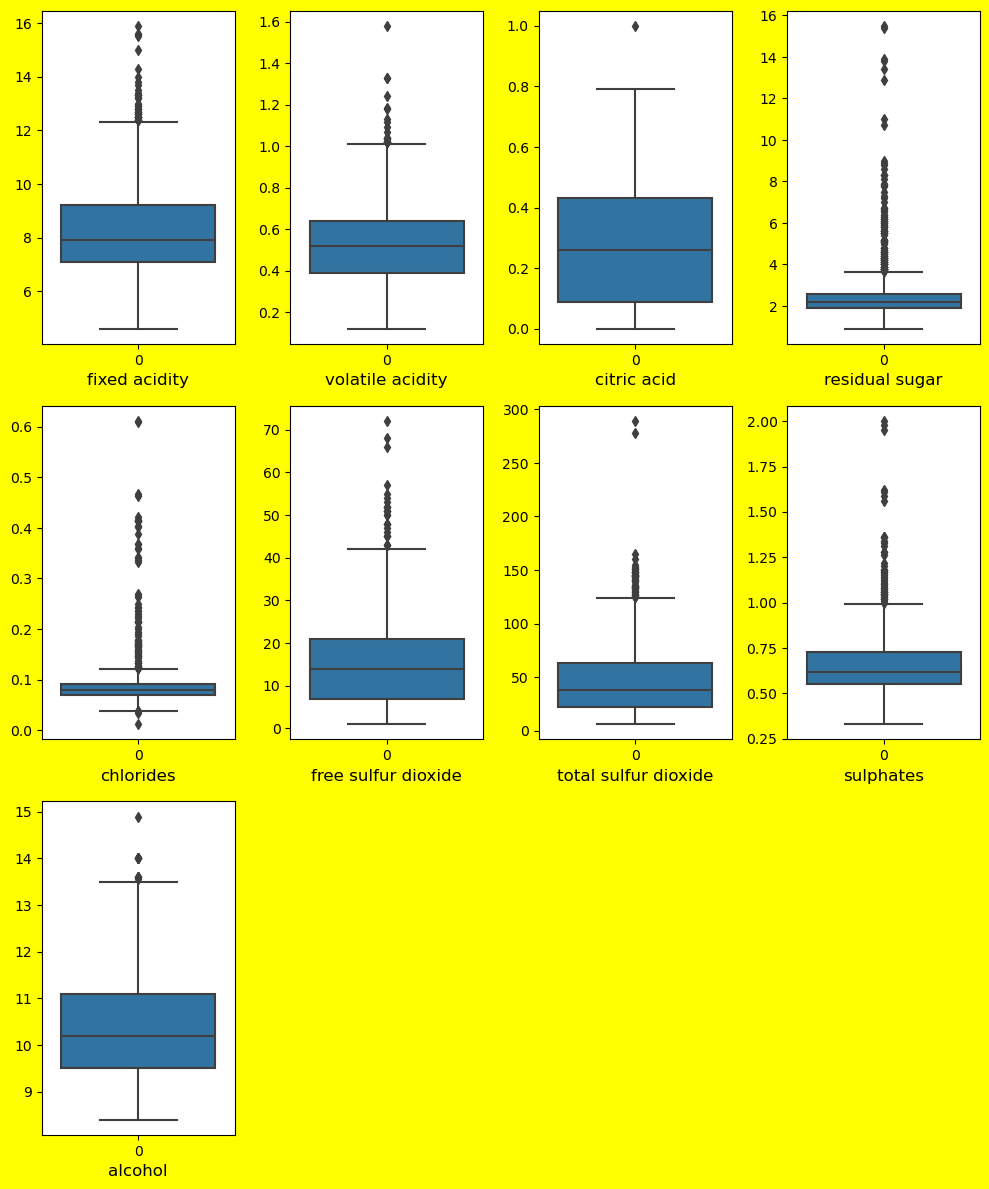

In [45]:
# Visualize the outliers using boxplot

plt.figure(figsize=(10,12), facecolor = 'yellow')
p = 1
for i in wine_quality_df_features:
    if p <= 11:
        ax = plt.subplot(3, 4, p)
        sns.boxplot(data = wine_quality_df_features[i])
        plt.xlabel(i, fontsize = 12)
    p = p + 1
plt.tight_layout()

In [46]:
wine_quality_df_features.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'sulphates',
       'alcohol'],
      dtype='object')

In [ ]:
observations:
            1. More Outliers found in features - 'fixed acidity', 'volatile acidity', 'residual sugar', 
               'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'sulphates'. 
                Most of this outliers are right skewed (i.e. outliers are above max value)
            2. Remove the outliers

## Find IQR to identify outliers and remove it

In [47]:
# there are situation we should remove outliers and sometime to keep outliers

q1 = wine_quality_df.quantile(0.25)
q3 = wine_quality_df.quantile(0.75)
iqr = q3 - q1

In [48]:
# validating one outlier

fixed_acidity_high = (q3['fixed acidity'] + (1.5 * iqr['fixed acidity']))
fixed_acidity_high

# anything > 12.349 outliers

12.349999999999998

In [49]:
# check the index which have the higher values

np_index = np.where(wine_quality_df['fixed acidity'] > fixed_acidity_high)
np_index

# remove these indexes as they are outliers

(array([ 182,  214,  232,  255,  285,  294,  295,  302,  308,  314,  318,
         319,  328,  334,  344,  357,  375,  383,  385,  389,  411,  413,
         444,  445,  449,  467,  473,  477,  483,  485,  486,  487,  517,
         520,  522,  531,  565,  588,  701,  704, 1042], dtype=int64),)

In [50]:
wine_quality_df.shape

(1359, 10)

In [51]:
wine_quality_df = wine_quality_df.drop(wine_quality_df.index[np_index])

In [52]:
wine_quality_df.shape  # 41 rows removed - outliers

(1318, 10)

In [53]:
wine_quality_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.58,9.8,6
4,7.4,0.660,0.00,1.8,0.075,13.0,40.0,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...
1354,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.82,9.5,6
1355,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.58,10.5,5
1356,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.76,11.2,6
1357,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.71,10.2,5


In [54]:
wine_quality_df.reset_index(inplace = True, drop = True)

In [55]:
wine_quality_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.58,9.8,6
4,7.4,0.660,0.00,1.8,0.075,13.0,40.0,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...
1313,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.82,9.5,6
1314,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.58,10.5,5
1315,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.76,11.2,6
1316,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.71,10.2,5


In [56]:
# validating another outlier

volatile_acidity_high = (q3['volatile acidity'] + (1.5 * iqr['volatile acidity']))
volatile_acidity_high

# anything > 1.015 outliers

1.0150000000000001

In [57]:
# check the index which have the higher values

np_index1 = np.where(wine_quality_df['volatile acidity'] > volatile_acidity_high)
np_index1

# remove these indexes as they are outliers

(array([  35,   86,  109,  114,  115,  121,  176,  454,  545,  559,  568,
         572,  577,  589,  731, 1033, 1065, 1076, 1203], dtype=int64),)

In [58]:
wine_quality_df.shape

(1318, 10)

In [59]:
wine_quality_df = wine_quality_df.drop(wine_quality_df.index[np_index1])

In [60]:
wine_quality_df.shape  # 19 rows removed - outliers

(1299, 10)

In [61]:
wine_quality_df.reset_index(inplace = True, drop = True)

In [62]:
wine_quality_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.58,9.8,6
4,7.4,0.660,0.00,1.8,0.075,13.0,40.0,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...
1294,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.82,9.5,6
1295,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.58,10.5,5
1296,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.76,11.2,6
1297,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.71,10.2,5


In [63]:
# validating another outlier

residual_sugar_high = (q3['residual sugar'] + (1.5 * iqr['residual sugar']))
residual_sugar_high

# anything > 3.65 outliers

3.6500000000000004

In [64]:
# check the index which have the higher values

np_index2 = np.where(wine_quality_df['residual sugar'] > residual_sugar_high)
np_index2

# remove these indexes as they are outliers

(array([   8,   12,   13,   16,   30,   32,   35,   50,   52,   59,  131,
         132,  138,  139,  164,  183,  227,  228,  229,  231,  232,  233,
         271,  273,  309,  311,  323,  324,  334,  338,  340,  370,  391,
         395,  404,  408,  417,  435,  437,  447,  476,  483,  485,  499,
         514,  518,  526,  572,  589,  639,  701,  710,  719,  725,  726,
         728,  731,  748,  751,  753,  776,  823,  829,  833,  844,  845,
         857,  862,  863,  865,  869,  876,  893,  910,  914,  923,  949,
         958,  960,  971,  988,  996,  999, 1004, 1015, 1031, 1041, 1046,
        1056, 1072, 1092, 1105, 1117, 1123, 1134, 1147, 1157, 1159, 1163,
        1167, 1187, 1190, 1193, 1212, 1224, 1225, 1248, 1260, 1265, 1276,
        1279, 1290], dtype=int64),)

In [65]:
wine_quality_df.shape

(1299, 10)

In [66]:
wine_quality_df = wine_quality_df.drop(wine_quality_df.index[np_index2])

In [67]:
wine_quality_df.shape # 112 rows removed - outliers

(1187, 10)

In [68]:
wine_quality_df.reset_index(inplace = True, drop = True)

In [69]:
wine_quality_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.58,9.8,6
4,7.4,0.660,0.00,1.8,0.075,13.0,40.0,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...
1182,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.82,9.5,6
1183,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.58,10.5,5
1184,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.76,11.2,6
1185,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.71,10.2,5


In [70]:
# validating another outlier

chlorides_high = (q3['chlorides'] + (1.5 * iqr['chlorides']))
chlorides_high

# anything > 0.122 outliers

0.12249999999999998

In [71]:
# check the index which have the higher values

np_index3 = np.where(wine_quality_df['chlorides'] > chlorides_high)
np_index3

# remove these indexes as they are outliers

(array([  12,   13,   30,   64,   66,   84,  100,  115,  119,  130,  139,
         178,  187,  201,  213,  220,  231,  235,  236,  255,  279,  332,
         335,  360,  361,  379,  381,  404,  411,  412,  447,  466,  485,
         502,  504,  532,  551,  567,  568,  570,  571,  574,  586,  587,
         596,  614,  615,  654,  674,  752,  776,  807,  816,  847,  863,
         882,  884,  893,  904,  926,  931,  932,  975,  985, 1012, 1013,
        1014, 1061, 1163], dtype=int64),)

In [72]:
wine_quality_df.shape

(1187, 10)

In [73]:
wine_quality_df = wine_quality_df.drop(wine_quality_df.index[np_index3])

In [74]:
wine_quality_df.shape  # 69 rows removed

(1118, 10)

In [75]:
wine_quality_df.reset_index(inplace = True, drop = True)

In [76]:
wine_quality_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.58,9.8,6
4,7.4,0.660,0.00,1.8,0.075,13.0,40.0,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...
1113,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.82,9.5,6
1114,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.58,10.5,5
1115,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.76,11.2,6
1116,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.71,10.2,5


In [77]:
# validating another outlier

sulphates_high = (q3['sulphates'] + (1.5 * iqr['sulphates']))
sulphates_high

# anything > 0.99 outliers

0.9999999999999999

In [78]:
# check the index which have the higher values

np_index4 = np.where(wine_quality_df['sulphates'] > sulphates_high)
np_index4

# remove these indexes as they are outliers

(array([ 10,  28,  59,  64,  66,  69, 115, 145, 238, 259, 262, 264, 334,
        348, 349, 351, 398, 435, 492, 583, 803, 945, 970, 974], dtype=int64),)

In [79]:
wine_quality_df.shape

(1118, 10)

In [80]:
wine_quality_df = wine_quality_df.drop(wine_quality_df.index[np_index4])

In [81]:
wine_quality_df.shape  # 24 rows removed

(1094, 10)

In [82]:
wine_quality_df.reset_index(inplace = True, drop = True)

In [83]:
wine_quality_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.58,9.8,6
4,7.4,0.660,0.00,1.8,0.075,13.0,40.0,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...
1089,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.82,9.5,6
1090,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.58,10.5,5
1091,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.76,11.2,6
1092,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.71,10.2,5


## Checking for Skewness

In [84]:
wine_quality_df.skew() # not in the range -0.5 to +0.5

fixed acidity           0.597262
volatile acidity        0.311203
citric acid             0.294157
residual sugar          0.568814
chlorides               0.095041
free sulfur dioxide     1.037015
total sulfur dioxide    1.208499
sulphates               0.620819
alcohol                 0.882254
quality                 0.346620
dtype: float64

In [85]:
# removing for skewness

wine_quality_df['total sulfur dioxide'] = np.cbrt(wine_quality_df['total sulfur dioxide'])

In [86]:
wine_quality_df['free sulfur dioxide'] = np.cbrt(wine_quality_df['free sulfur dioxide'])

wine_quality_df['alcohol'] = np.cbrt(wine_quality_df['alcohol'])

In [87]:
wine_quality_df.skew()

fixed acidity           0.597262
volatile acidity        0.311203
citric acid             0.294157
residual sugar          0.568814
chlorides               0.095041
free sulfur dioxide     0.178305
total sulfur dioxide    0.323836
sulphates               0.620819
alcohol                 0.756634
quality                 0.346620
dtype: float64

In [ ]:
Observation:
            1. 'sulphates' and 'alcohol' are litte more than +0.5
            2. Almost all other features - there is no skewness

## Data Imbalance use Oversampling method

In [88]:
x = wine_quality_df.drop(columns = ['quality'])
y = wine_quality_df['quality']

In [89]:
y.value_counts()

5    469
6    446
7    129
4     34
8     13
3      3
Name: quality, dtype: int64

In [90]:
y.shape

(1094,)

In [91]:
# set an arbitrary cutoff for your dependent variable (wine quality) at e.g. 7 or higher getting 
# classified as 'good/1' and the remainder as 'not good/0'.

y1 = wine_quality_df['quality'].apply(lambda i:1 if i >= 7 else 0)

In [92]:
y1.value_counts()

0    952
1    142
Name: quality, dtype: int64

Observation:
            1. Good wine quality represents '1' and Bad wine quality represents '0'

In [609]:
!pip install imblearn

In [93]:
from imblearn.over_sampling import SMOTE

over_samp = SMOTE(random_state = 41, k_neighbors = 3, sampling_strategy = 0.75)
x2, y2 = over_samp.fit_resample(x, y1)

In [94]:
y2.value_counts()

0    952
1    714
Name: quality, dtype: int64

Observation:
            1. Good wine quality represents '1' and Bad wine quality represents '0'

## Modelling

In [95]:
# creating train_test_split

x_train, x_test, y_train, y_test = train_test_split(x2, y2, test_size = 0.25, random_state = 41)

In [96]:
# Function to check accuracy of different models

def metric_score(clf, x_train, x_test, y_train, y_test, train = True):
    if train == True:
        y_pred = clf.predict(x_train)
        print("Train Result ")
        print(f'Accuracy Score: {accuracy_score(y_train, y_pred) * 100 : .2f}%')
    elif train == False:
        pred = clf.predict(x_test)
        print("Test Result ")
        print(f'Accuracy Score: {accuracy_score(y_test, pred) * 100 : .2f}%')
        print("Test Classification Report \n", classification_report(y_test, pred, digits = 2))

In [97]:
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)

DecisionTreeClassifier()

In [98]:
# This is the training score

metric_score(dt, x_train, x_test, y_train, y_test, train = True)

Train Result 
Accuracy Score:  100.00%


In [99]:
# This is the testing score

metric_score(dt, x_train, x_test, y_train, y_test, train = False)

Test Result 
Accuracy Score:  86.09%
Test Classification Report 
               precision    recall  f1-score   support

           0       0.93      0.81      0.87       232
           1       0.80      0.92      0.85       185

    accuracy                           0.86       417
   macro avg       0.86      0.87      0.86       417
weighted avg       0.87      0.86      0.86       417



Observation:
            1. Training Accuracy - 100%
            2. Testing Accuracy - 86.09% we can also try to improve the testing accuracy

In [100]:
# to check the confusion matrix

y_pred = dt.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[189,  43],
       [ 15, 170]], dtype=int64)

## Hypertuning Parameters

In [102]:
parameters = {'criterion': ['gini', 'entropy'], 'max_depth': range(10, 15), 'min_samples_leaf': range(2, 6), 'min_samples_split': range(3, 8), 'max_leaf_nodes': range(5, 40)}

In [103]:
gridsearch = GridSearchCV(estimator = dt, param_grid = parameters, cv = 5, n_jobs = -1)

In [104]:
gridsearch.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(10, 15),
                         'max_leaf_nodes': range(5, 40),
                         'min_samples_leaf': range(2, 6),
                         'min_samples_split': range(3, 8)})

In [105]:
best_parameters = gridsearch.best_params_

In [106]:
print(best_parameters)

{'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 39, 'min_samples_leaf': 3, 'min_samples_split': 3}


## Again Retrain the model with hyper-tuned parameters 

In [107]:
dt_h1 = DecisionTreeClassifier(criterion = 'entropy', max_depth = 10, max_leaf_nodes = 39, min_samples_leaf = 3, min_samples_split = 3)

In [108]:
dt_h1.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, max_leaf_nodes=39,
                       min_samples_leaf=3, min_samples_split=3)

In [109]:
# This is the training score after hyperparameter tuning

metric_score(dt_h1, x_train, x_test, y_train, y_test, train = True)

Train Result 
Accuracy Score:  92.95%


In [110]:
# This is the testing score after hyperparameter tuning

metric_score(dt_h1, x_train, x_test, y_train, y_test, train = False)

Test Result 
Accuracy Score:  85.61%
Test Classification Report 
               precision    recall  f1-score   support

           0       0.89      0.84      0.87       232
           1       0.82      0.87      0.84       185

    accuracy                           0.86       417
   macro avg       0.85      0.86      0.86       417
weighted avg       0.86      0.86      0.86       417



In [ ]:
Observation:
            1. Training Accuracy - 92.95%
            2. Testing Accuracy - 85.61% we have tried to improve the testing accuracy

## Plot ROC curve and AUC value

In [117]:
pred = dt_h1.predict(x_test)
acc = accuracy_score(y_test, pred)
print(acc)

0.8561151079136691


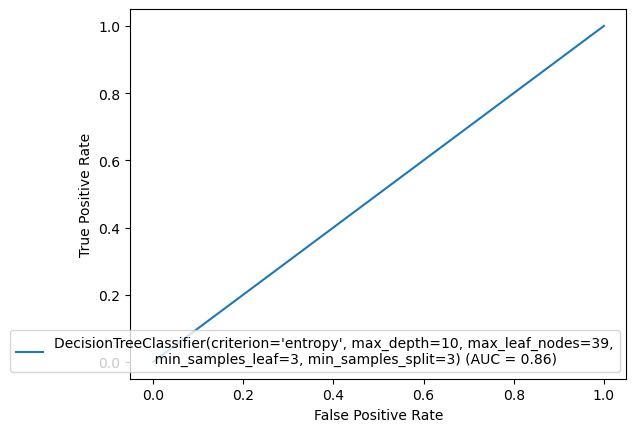

In [118]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
roc_curve = metrics.RocCurveDisplay(fpr = tpr, tpr = tpr, roc_auc = roc_auc, estimator_name = dt_h1)
roc_curve.plot()

## Save the Model

In [127]:
import pickle
pickle.dump(dt_h1, open('Red_Wine_Model.pkl', 'wb'))

## prediction using the saved model

In [128]:
loaded_model = pickle.load(open('Red_Wine_Model.pkl', 'rb'))
prediction_saved_model = loaded_model.predict(x_test)
prediction_saved_model

array([1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,

In [129]:
print(y_test)

1187    1
31      0
472     0
1352    1
659     0
       ..
614     0
391     0
357     0
252     0
622     1
Name: quality, Length: 417, dtype: int64


Observation:
            1. Almost actual and predicted values match
            2. This Red_Wine_Model.pkl can be used to classify whether the Red Wine quality is 
               good or bad. Good quality represents '1' and Bad quality represents '0'